In [ ]:
import os
import cv2
import tensorflow
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
img_files = next(os.walk('/content/drive/MyDrive/Skin/skin/ISIC-2017_Training_Data/ISIC-2017_Training_Data'))[2]
msk_files = next(os.walk('/content/drive/MyDrive/Skin/skin/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth'))[2]

img_files.sort()
msk_files.sort()

print(len(img_files))
print(len(msk_files))




X = []
Y = []

for img_fl in tqdm(img_files):
    if(img_fl.split('.')[-1]=='jpg'):


        img = cv2.imread('/content/drive/MyDrive/Skin/skin/ISIC-2017_Training_Data/ISIC-2017_Training_Data/{}'.format(img_fl), cv2.IMREAD_COLOR)
        resized_img = cv2.resize(img,(128,128), interpolation = cv2.INTER_CUBIC)

        X.append(resized_img)

        msk = cv2.imread('/content/drive/MyDrive/Skin/skin/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth/{}'.format(img_fl.split('.')[0]+'_segmentation.png'), cv2.IMREAD_GRAYSCALE)
        resized_msk = cv2.resize(msk,(128,128), interpolation = cv2.INTER_CUBIC)

        Y.append(resized_msk)


In [ ]:
print(len(X))
print(len(Y))

X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1))

X_train = X_train / 255
X_test = X_test / 255
Y_train = Y_train / 255
Y_test = Y_test / 255

Y_train = np.round(Y_train,0)
Y_test = np.round(Y_test,0)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

In [ ]:
X_train1, X_test_do, Y_train1, Y_test_d0 = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [ ]:
print(X_train1.shape)
print(Y_train1.shape)
print(X_test_do.shape)
print(Y_test_d0.shape)

In [ ]:
import tensorflow as tf
from sklearn.utils.extmath import cartesian
import math
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth)
    return tp

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn
def cdist(A, B):
    """
    Computes the pairwise Euclidean distance matrix between two tensorflow matrices A & B, similiar to scikit-learn cdist.
    For example:
    A = [[1, 2],
         [3, 4]]
    B = [[1, 2],
         [3, 4]]
    should return:
        [[0, 2.82],
         [2.82, 0]]
    :param A: m_a x n matrix
    :param B: m_b x n matrix
    :return: euclidean distance matrix (m_a x m_b)
    """
    # squared norms of each row in A and B
    na = tf.reduce_sum(tf.square(A), 1)
    nb = tf.reduce_sum(tf.square(B), 1)

    # na as a row and nb as a co"lumn vectors
    na = tf.reshape(na, [-1, 1])
    nb = tf.reshape(nb, [1, -1])

    # return pairwise euclidead difference matrix
    D = tf.sqrt(tf.maximum(na - 2 * tf.matmul(A, B, False, True) + nb, 0.0))
    return D


def weighted_hausdorff_distance(w, h, alpha):
    all_img_locations = tf.convert_to_tensor(cartesian([np.arange(w), np.arange(h)]), dtype=tf.float32)
    max_dist = math.sqrt(w ** 2 + h ** 2)

    def hausdorff_loss(y_true, y_pred):
        def loss(y_true, y_pred):
            eps = 1e-6
            y_true = K.reshape(y_true, [w, h])
            gt_points = K.cast(tf.where(y_true > 0.5), dtype=tf.float32)
            num_gt_points = tf.shape(gt_points)[0]
            y_pred = K.flatten(y_pred)
            p = y_pred
            p_replicated = tf.squeeze(K.repeat(tf.expand_dims(p, axis=-1), num_gt_points))
            d_matrix = cdist(all_img_locations, gt_points)
            num_est_pts = tf.reduce_sum(p)
            term_1 = (1 / (num_est_pts + eps)) * K.sum(p * K.min(d_matrix, 1))

            d_div_p = K.min((d_matrix + eps) / (p_replicated ** alpha + (eps / max_dist)), 0)
            d_div_p = K.clip(d_div_p, 0, max_dist)
            term_2 = K.mean(d_div_p, axis=0)

            return term_1 + term_2

        batched_losses = tf.map_fn(lambda x:
                                   loss(x[0], x[1]),
                                   (y_true, y_pred),
                                   dtype=tf.float32)
        return K.mean(tf.stack(batched_losses))

    return hausdorff_loss

In [ ]:
!pip install segmentation_models

In [ ]:
!pip install keras_unet_collection

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
from keras_unet_collection import losses

def hybrid_loss(y_true, y_pred):

    loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
    loss_iou = losses.iou_seg(y_true, y_pred)

    # (x)
    loss_dice = losses.dice(y_true, y_pred)

    return loss_focal+loss_iou +loss_dice

In [ ]:
from tensorflow.keras import models, layers, regularizers
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn




FILTER_NUM = 64 # number of filters for the first layer
FILTER_SIZE = 3 # size of the convolutional filter
UP_SAMP_SIZE = 2 # size of upsampling filters

NUM_CLASSES=1
dropout_rate=0.0
batch_norm=True
input_shape = (128,128,3)
inputs = layers.Input(input_shape, dtype=tf.float32)

# Downsampling layers
# DownRes 1, convolution + pooling
conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
# DownRes 2
conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
# DownRes 3
conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
# DownRes 4
conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
# DownRes 5, convolution only
conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

# Upsampling layers

up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
up_16 = layers.concatenate([up_16, conv_16], axis=3)
up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
# UpRes 7

up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
up_32 = layers.concatenate([up_32, conv_32], axis=3)
up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
# UpRes 8

up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
up_64 = layers.concatenate([up_64, conv_64], axis=3)
up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
# UpRes 9

up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
up_128 = layers.concatenate([up_128, conv_128], axis=3)
up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

# 1*1 convolutional layers

conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
conv_final = layers.BatchNormalization(axis=3)(conv_final)
conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

# Model
model = models.Model(inputs, conv_final, name="UNet")
print(model.summary())


In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow
import segmentation_models as sm
model.compile(loss = hybrid_loss, optimizer=Adam(lr = 1e-3), metrics=['accuracy',dice_coef,jacard, confusion,tp,tn,recall_m,precision_m])
#print(model_Unet.summary())
#sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)


In [ ]:
steps_per_epoch = len(X_train1)//16
val_steps_per_epoch = len(X_test)//16

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval.
filepath="/content/drive/MyDrive/Skin/paper/weights/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
#early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('/content/drive/MyDrive/Skin/paper/weights/UNET_SKIN_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, log_csv]


In [ ]:
from datetime import datetime
batch_size=16
start1 = datetime.now()

Unet_history = model.fit(X_train1, Y_train1,
                    verbose=1,epochs=500,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(X_test, Y_test),
                    validation_steps=val_steps_per_epoch
                   )

stop1 = datetime.now()
#Execution time of the model
execution_time_Unet = stop1-start1
print("MADR execution time is: ", execution_time_Unet)
model.save('/content/drive/MyDrive/Skin/weight/consolidate/UNET_SKIN_model.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/Skin/weight/consolidate/UNET_SKIN_model.h5')

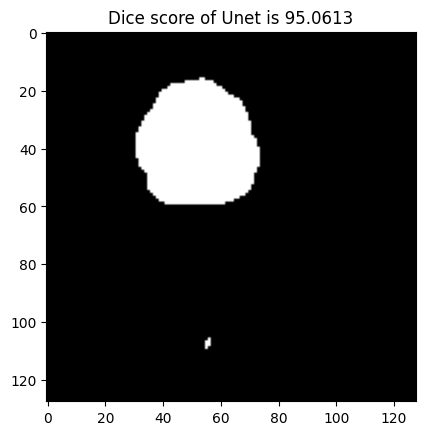

In [ ]:
import random
from tensorflow.keras.utils import normalize
test_img_number =122
test_img = X_test_do[test_img_number]
ground_truth=Y_test_d0[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

seg=prediction
gt=ground_truth[:,:,0]
dice = (np.sum(seg[gt==1])*2.0 / (np.sum(seg) + np.sum(gt)))*100
dice=round(dice,4)
plt.title(f"Dice score of Unet is {dice}",fontsize=12)
plt.imshow(prediction, cmap='gray')